## Pipeline OCR (Tesseract + OpenCV).

Langue (par défaut FR, mais bascule en EN si détecté)

Par défaut, l’OCR est en français :

DEFAULT_LANG = "fra" (côté Tesseract)

spacy.load("fr_core_news_sm", ...) (côté spaCy)

Si tu détectes que le texte est en anglais, tu fais basculer :

DEFAULT_LANG = "eng" (ou fra+eng si tu veux tolérer les deux)

spacy.load("en_core_web_sm", ...)

Trucs à modifier quand tu changes de langue :

la constante DEFAULT_LANG

le modèle spaCy chargé (fr_core_news_sm ↔ en_core_web_sm)

---

Fonctionnement global du script

Prendre une image (INPUT_FILE)

L’améliorer via le prétraitement (gris, upscale, contraste/sharpness, seuil, etc.)

Lancer Tesseract sur l’image prétraitée pour extraire le texte (OCR_TEXT)

### importation img et prétraitement

In [43]:
from typing import Optional

INPUT_FILE: Optional[str] = "signettab.png"

[info] Using INPUT_FILE=C:\Users\moura\OneDrive\Bureau\DMS\test\signettab.png


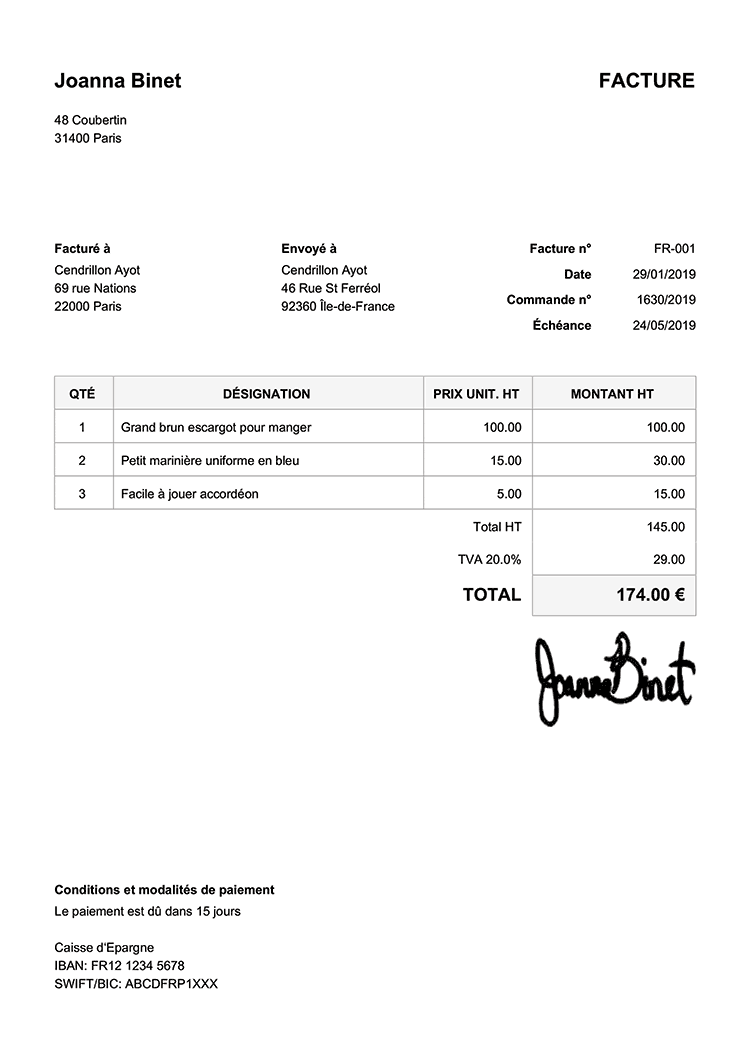

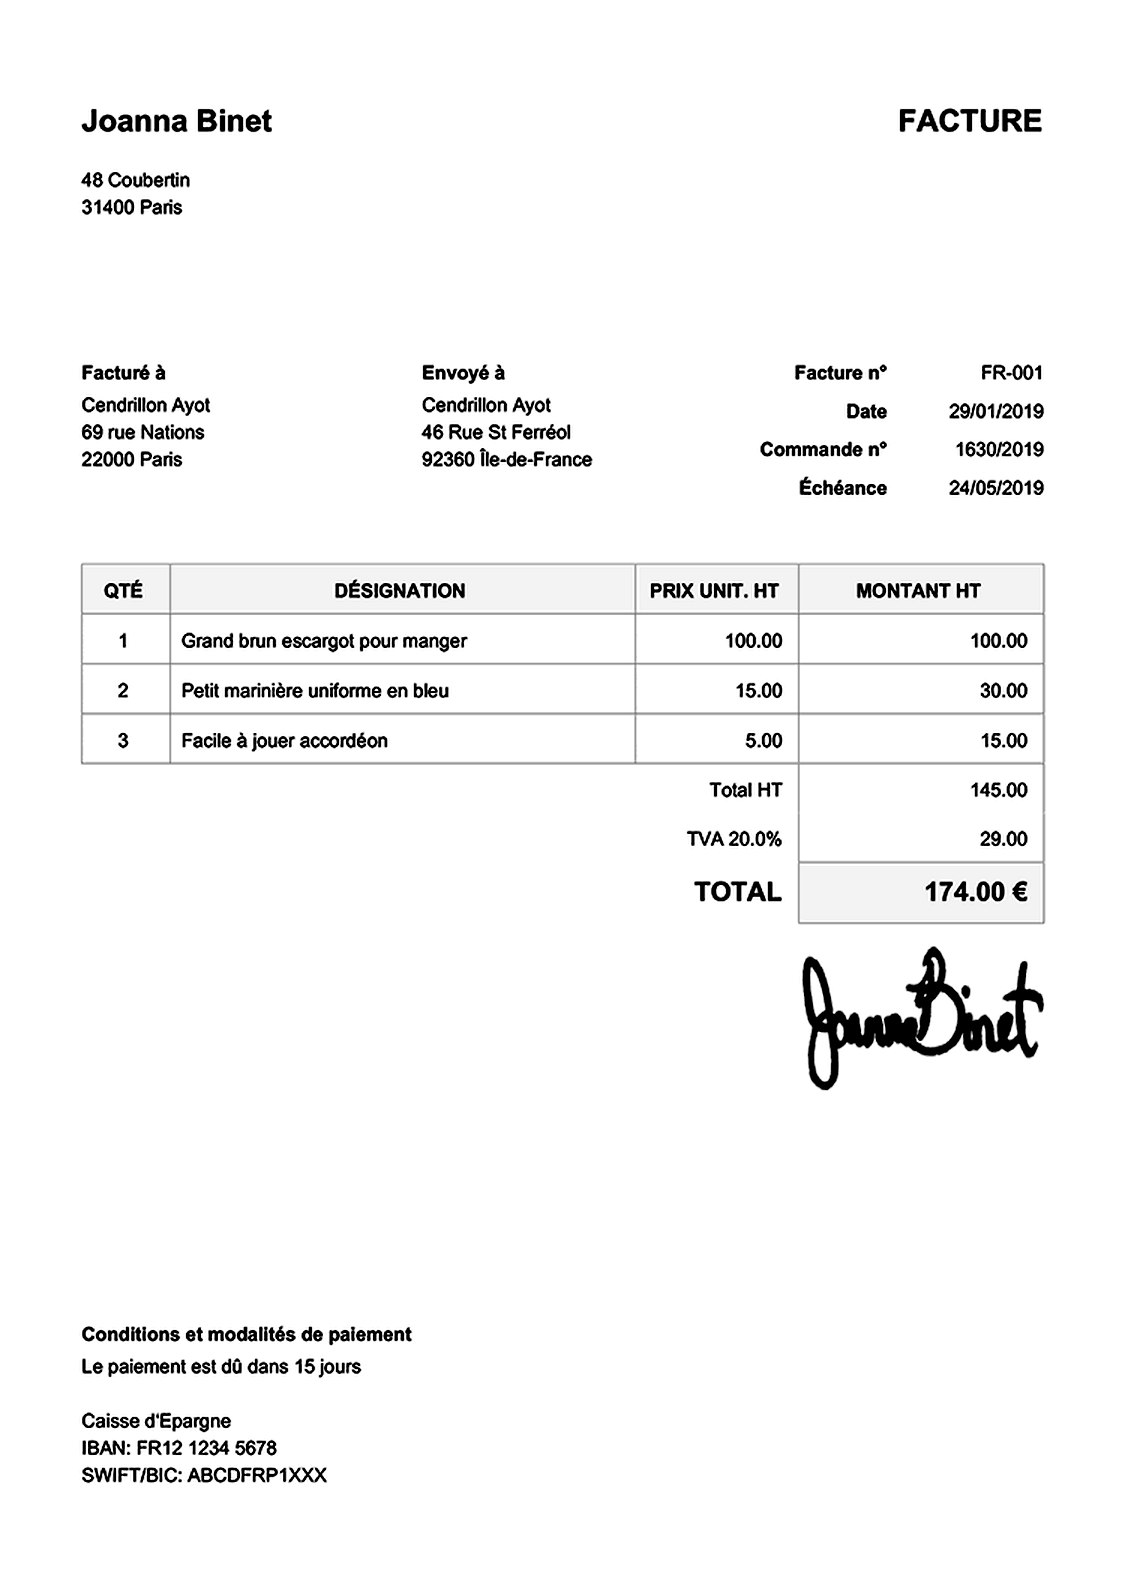

In [44]:
"""
Dependencies:
  * Python 3.8+
  * pytesseract
  * pillow
  * Tesseract binary with tessdata
"""

import argparse
import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Optional, Tuple

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

try:
    import numpy as np  # type: ignore
except ImportError:  # pragma: no cover
    np = None

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # In notebooks __file__ is undefined; fall back to current working directory.
    SCRIPT_DIR = Path.cwd()

DEFAULT_LANG = "fra"
DEFAULT_CONTRAST = 1.5
DEFAULT_SHARPNESS = 1.2
DEFAULT_BRIGHTNESS = 1.0
DEFAULT_UPSCALE = 1.5
DEFAULT_DPI = 300

 #/////////////////////////////////////////////////////////////////////////////////////////////////////////////////
SHOW_PREPROCESSED = True


@dataclass
class EnhanceOptions:
    contrast: float = DEFAULT_CONTRAST
    sharpness: float = DEFAULT_SHARPNESS
    brightness: float = DEFAULT_BRIGHTNESS
    upscale: float = DEFAULT_UPSCALE
    gamma: Optional[float] = None  # gamma correction; <1 brightens darks, >1 darkens
    pad: int = 0  # pixels to pad around the image
    median: Optional[int] = None  # kernel size for median filter (odd int, e.g., 3)
    unsharp_radius: Optional[float] = None  # e.g., 1.0
    unsharp_percent: int = 150
    invert: bool = False
    autocontrast_cutoff: Optional[int] = None  # 0-100; percentage to clip for autocontrast
    equalize: bool = False  # histogram equalization
    auto_rotate: bool = False  # attempt orientation detection + rotate
    otsu: bool = False  # auto-threshold with Otsu (requires numpy)
    threshold: Optional[int] = None  # 0-255; if set, applies a binary threshold


def build_config(
    oem: Optional[int],
    psm: Optional[int],
    base_flags: Iterable[str],
    dpi: Optional[int],
    tessdata_dir: Optional[Path],
    user_words: Optional[Path],
    user_patterns: Optional[Path],
) -> str:
    parts: List[str] = []
    if oem is not None:
        parts.append(f"--oem {oem}")
    if psm is not None:
        parts.append(f"--psm {psm}")
    if dpi is not None:
        parts.append(f"--dpi {dpi}")
    if tessdata_dir is not None:
        parts.append(f'--tessdata-dir "{tessdata_dir}"')
    if user_words is not None:
        parts.append(f'--user-words "{user_words}"')
    if user_patterns is not None:
        parts.append(f'--user-patterns "{user_patterns}"')
    parts.extend(base_flags)
    return " ".join(parts)


def ensure_environment(lang: str) -> None:
    try:
        _ = pytesseract.get_tesseract_version()
    except pytesseract.TesseractNotFoundError:
        sys.exit("Tesseract binary not found on PATH. Install it and its language data.")
    if lang:
        try:
            available = set(pytesseract.get_languages(config=""))
            requested = set(lang.split("+"))
            missing = requested - available
            if missing:
                print(
                    f"Warning: missing languages: {', '.join(sorted(missing))}. "
                    f"Available: {', '.join(sorted(available))}",
                    file=sys.stderr,
                )
        except pytesseract.TesseractError:
            pass


def auto_rotate_if_needed(img: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    if not enhance.auto_rotate:
        return img
    try:
        osd = pytesseract.image_to_osd(img)
        angle = None
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                try:
                    angle = int(line.split(":")[1].strip())
                except ValueError:
                    angle = None
                break
        if angle is not None and angle % 360 != 0:
            return img.rotate(-angle, expand=True)
    except Exception:
        pass
    return img


def preprocess_image(image: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    img = image.convert("L")
    img = auto_rotate_if_needed(img, enhance)

    if enhance.invert:
        img = ImageOps.invert(img)

    if enhance.pad and enhance.pad > 0:
        img = ImageOps.expand(img, border=enhance.pad, fill=255)

    if enhance.autocontrast_cutoff is not None:
        cutoff = max(0, min(100, enhance.autocontrast_cutoff))
        img = ImageOps.autocontrast(img, cutoff=cutoff)

    if enhance.equalize:
        img = ImageOps.equalize(img)

    if enhance.upscale and enhance.upscale != 1.0:
        w, h = img.size
        img = img.resize((int(w * enhance.upscale), int(h * enhance.upscale)), Image.LANCZOS)

    if enhance.gamma and enhance.gamma > 0:
        inv_gamma = 1.0 / enhance.gamma
        lut = [pow(x / 255.0, inv_gamma) * 255 for x in range(256)]
        img = img.point(lut)

    if enhance.brightness and enhance.brightness != 1.0:
        img = ImageEnhance.Brightness(img).enhance(enhance.brightness)

    if enhance.contrast and enhance.contrast != 1.0:
        img = ImageEnhance.Contrast(img).enhance(enhance.contrast)

    if enhance.sharpness and enhance.sharpness != 1.0:
        img = ImageEnhance.Sharpness(img).enhance(enhance.sharpness)

    if enhance.unsharp_radius:
        img = img.filter(
            ImageFilter.UnsharpMask(
                radius=enhance.unsharp_radius,
                percent=enhance.unsharp_percent,
                threshold=0,
            )
        )

    if enhance.median and enhance.median > 1 and enhance.median % 2 == 1:
        img = img.filter(ImageFilter.MedianFilter(size=enhance.median))

    if enhance.threshold is not None:
        thr = max(0, min(255, enhance.threshold))
        img = img.point(lambda p, t=thr: 255 if p > t else 0, mode="1").convert("L")
    elif enhance.otsu and np is not None:
        arr = np.array(img, dtype=np.uint8)
        hist, _ = np.histogram(arr, bins=256, range=(0, 256))
        total = arr.size
        sum_total = np.dot(np.arange(256), hist)

        sum_b = 0.0
        w_b = 0.0
        max_var = 0.0
        threshold = 0

        for i in range(256):
            w_b += hist[i]
            if w_b == 0:
                continue
            w_f = total - w_b
            if w_f == 0:
                break
            sum_b += i * hist[i]
            m_b = sum_b / w_b
            m_f = (sum_total - sum_b) / w_f
            var_between = w_b * w_f * (m_b - m_f) ** 2
            if var_between > max_var:
                max_var = var_between
                threshold = i

        img = img.point(lambda p, t=threshold: 255 if p > t else 0, mode="1").convert("L")

    return img


def parse_args(argv: Optional[Iterable[str]] = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("-l", "--lang", default=DEFAULT_LANG)
    parser.add_argument("--oem", type=int, choices=range(0, 4), default=None)
    parser.add_argument("--psm", type=int, choices=range(0, 14), default=None)
    parser.add_argument("--dpi", type=int, default=DEFAULT_DPI)
    parser.add_argument("--tessdata-dir", type=Path, default=None)
    parser.add_argument("--user-words", type=Path, default=None)
    parser.add_argument("--user-patterns", type=Path, default=None)
    parser.add_argument("--whitelist", type=str, default=None)
    parser.add_argument("--blacklist", type=str, default=None)

    parser.add_argument("--contrast", type=float, default=DEFAULT_CONTRAST)
    parser.add_argument("--sharpness", type=float, default=DEFAULT_SHARPNESS)
    parser.add_argument("--brightness", type=float, default=DEFAULT_BRIGHTNESS)
    parser.add_argument("--upscale", type=float, default=DEFAULT_UPSCALE)
    parser.add_argument("--gamma", type=float, default=None)
    parser.add_argument("--pad", type=int, default=0)
    parser.add_argument("--threshold", type=int, default=None)
    parser.add_argument("--median", type=int, default=None)
    parser.add_argument("--unsharp-radius", type=float, default=None)
    parser.add_argument("--unsharp-percent", type=int, default=150)
    parser.add_argument("--invert", action="store_true")
    parser.add_argument("--autocontrast-cutoff", type=int, default=None)
    parser.add_argument("--equalize", action="store_true")
    parser.add_argument("--auto-rotate", action="store_true")
    parser.add_argument("--otsu", action="store_true")

    parser.add_argument(
        "--config",
        nargs="*",
        default=[],
        metavar="CFG",
        help="Additional configuration flags passed verbatim to tesseract (e.g., -c foo=bar).",
    )

    return parser.parse_args(list(argv) if argv is not None else [])


# --------- Exécution Cellule 1 (jusqu’à l’affichage) ---------

args = parse_args()
ensure_environment(args.lang)

enhance = EnhanceOptions(
    contrast=args.contrast,
    sharpness=args.sharpness,
    brightness=args.brightness,
    upscale=args.upscale,
    gamma=args.gamma,
    pad=args.pad,
    median=args.median,
    unsharp_radius=args.unsharp_radius,
    unsharp_percent=args.unsharp_percent,
    invert=args.invert,
    autocontrast_cutoff=args.autocontrast_cutoff,
    equalize=args.equalize,
    auto_rotate=args.auto_rotate,
    otsu=args.otsu,
    threshold=args.threshold,
)

config_flags: List[str] = list(args.config)
if args.whitelist:
    config_flags.append(f"-c tessedit_char_whitelist={args.whitelist}")
if args.blacklist:
    config_flags.append(f"-c tessedit_char_blacklist={args.blacklist}")

if not INPUT_FILE:
    sys.exit("INPUT_FILE is not set. Put your image filename in INPUT_FILE.")

path = Path(INPUT_FILE)
if not path.is_absolute():
    path = (SCRIPT_DIR / path).resolve()

if not path.exists():
    sys.exit(f"INPUT_FILE not found: {path}")

print(f"[info] Using INPUT_FILE={path}", file=sys.stderr)

original = Image.open(path)
prepped = preprocess_image(original, enhance)

from IPython.display import display

display(original.convert("RGB") if original.mode not in ("RGB","L") else original)

if "SHOW_PREPROCESSED" not in globals() or SHOW_PREPROCESSED:
    display(prepped.convert("RGB") if prepped.mode not in ("RGB","L") else prepped)



### tesseract

In [45]:
config = build_config(
    args.oem,
    args.psm,
    config_flags,
    args.dpi,
    args.tessdata_dir,
    args.user_words,
    args.user_patterns,
)

OCR_TEXT = pytesseract.image_to_string(prepped, lang=args.lang, config=config)
print(OCR_TEXT)


Joanna Binet

48 Coubertin
31400 Paris
Facturé à Envoyé à
Cendrillon Ayot Cendrillon Ayot
69 rue Nations 46 Rue St Ferréol
22000 Paris 92360 Île-de-France
QTÉ DÉSIGNATION

1 Grand brun escargot pour manger

2 Petit marinière uniforme en bleu

3 Facile à jouer accordéon
C et de

Le paiement est dû dans 15 jours

Caisse d'Epargne
IBAN: FR12 1234 5678
SWIFT/BIC: ABCDFRP1XXX

FACTURE
Facture n° FR-001
Date 29/01/2019
Commande n° 1630/2019
Échéance 24/05/2019
PRIX UNIT. HT MONTANT HT
100.00 100.00
15.00 30.00
5.00 15.00
Total HT 145.00
TVA 20.0% 29.00
TOTAL 174.00 €



### Pipeline SpaCy de base & Tokenisation

modifer pour la langue :fr_core_news_sm

In [46]:
import re
import spacy
from langdetect import detect

texte = OCR_TEXT

# 1) détecter la langue sur un gros extrait (plus stable et plus rapide)
sample = texte[:2000]  
try:
    doc_lang = detect(sample)
except:
    doc_lang = "fr"  # si probleme avec detection de langue (on forcer fr)
 
# 2) charger UN seul modèle
nlp = spacy.load("fr_core_news_sm", disable=["parser", "tagger", "ner", "lemmatizer"])
# nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner", "lemmatizer"])

# 3) split phrases rapide
sent_split = re.compile(r'(?<=[.!?])\s+')

for phrase in sent_split.split(texte):
    phrase = phrase.strip()
    if len(phrase) < 20:
        continue

    # tokenisation spaCy (mais pipeline ultra léger)
    doc = nlp.make_doc(phrase)
    print("\nPhrase :", phrase)
    print("Langue :", doc_lang)
    print("Tokens :", [t.text for t in doc])



Phrase : Joanna Binet

48 Coubertin
31400 Paris
Facturé à Envoyé à
Cendrillon Ayot Cendrillon Ayot
69 rue Nations 46 Rue St Ferréol
22000 Paris 92360 Île-de-France
QTÉ DÉSIGNATION

1 Grand brun escargot pour manger

2 Petit marinière uniforme en bleu

3 Facile à jouer accordéon
C et de

Le paiement est dû dans 15 jours

Caisse d'Epargne
IBAN: FR12 1234 5678
SWIFT/BIC: ABCDFRP1XXX

FACTURE
Facture n° FR-001
Date 29/01/2019
Commande n° 1630/2019
Échéance 24/05/2019
PRIX UNIT.
Langue : fr
Tokens : ['Joanna', 'Binet', '\n\n', '48', 'Coubertin', '\n', '31400', 'Paris', '\n', 'Facturé', 'à', 'Envoyé', 'à', '\n', 'Cendrillon', 'Ayot', 'Cendrillon', 'Ayot', '\n', '69', 'rue', 'Nations', '46', 'Rue', 'St', 'Ferréol', '\n', '22000', 'Paris', '92360', 'Île-de-France', '\n', 'QTÉ', 'DÉSIGNATION', '\n\n', '1', 'Grand', 'brun', 'escargot', 'pour', 'manger', '\n\n', '2', 'Petit', 'marinière', 'uniforme', 'en', 'bleu', '\n\n', '3', 'Facile', 'à', 'jouer', 'accordéon', '\n', 'C', 'et', 'de', '\n\n', '

## Schéma de BDD 

In [47]:
from IPython.display import HTML, display
import re, json, uuid

raw = r"""
---
config:
  layout: elk
  theme: redux-dark-color
---

erDiagram
    ROLES {
        INT id PK
        VARCHAR name
    }

    USERS {
        INT id PK
        VARCHAR username
        VARCHAR email
        VARCHAR password_hash
        INT role_id FK
        DATETIME created_at
    }

    DOMAINS {
        INT id PK
        VARCHAR name
    }

    RULE_CONFIGS {
        INT id PK
        INT domain_id FK
        VARCHAR version_label_Regex
        JSONB Regex_json
        INT created_by FK
        DATETIME created_at
        BOOLEAN is_active
    }

    %% Nouvelle table: "API" = profil/config par domaine (langue, règles, paramètres)
    APIS {
        INT id PK
        INT domain_id FK
        INT rule_config_id FK
        VARCHAR name
        VARCHAR language_code          
        JSONB settings_json           
        BOOLEAN is_active
        INT created_by FK
        DATETIME created_at
    }

    %% Clés par API (une API/profil peut avoir plusieurs clés d'accès)
    API_KEYS {
        INT id PK
        INT api_id FK
        VARCHAR key_hash              
        JSONB scopes                  
        DATETIME created_at
        DATETIME last_used_at
        DATETIME expires_at
        DATETIME revoked_at
    }

    DOCUMENTS {
        UUID id PK
        VARCHAR filename
        INT domain_id FK
        VARCHAR status
        VARCHAR empreinte_numerique
        DATETIME uploaded_at
        INT uploaded_by FK
        INT api_id FK                 
    }

    FILE_STORAGE {
        INT id PK
        UUID document_id FK
        VARCHAR object_path
        INT size
        VARCHAR empreinte_numerique
        DATETIME stored_at
    }

    EXTRACTIONS {
        INT id PK
        UUID document_id FK
        INT rule_config_id FK
        VARCHAR field_name
        TEXT extracted_value
        JSONB coordinates
        BOOLEAN is_valid
        BOOLEAN is_overridden
        INT overridden_by FK
        DATETIME overridden_at
    }

    QUALITY_GATE_LOGS {
        INT id PK
        UUID document_id FK
        BOOLEAN is_passed
        TEXT failure_reason
        DATETIME checked_at
        VARCHAR check_origin          
        INT checked_by FK            
        BOOLEAN is_final_decision    
        TEXT decision_comment
    }

    AUDIT_LOGS {
        INT id PK
        INT user_id FK
        UUID document_id FK
        VARCHAR action
        VARCHAR entity_type
        INT entity_id
        JSONB changes
        DATETIME timestamp
        VARCHAR ip_address
    }

    %% Relations façon Workbench
    ROLES ||--o{ USERS : "role_id"
    USERS ||--o{ RULE_CONFIGS : "created_by"
    USERS ||--o{ AUDIT_LOGS : "user_id"

    DOMAINS ||--o{ RULE_CONFIGS : "domain_id"

    %% Domaine -> APIs (plusieurs APIs dans le même domaine)
    DOMAINS ||--o{ APIS : "domain_id"
    RULE_CONFIGS ||--o{ APIS : "rule_config_id"
    USERS ||--o{ APIS : "created_by"

    %% API -> API_KEYS (plusieurs clés par API)
    APIS ||--o{ API_KEYS : "api_id"

    %% Domaine -> Documents
    DOMAINS ||--o{ DOCUMENTS : "domain_id"
    USERS ||--o{ DOCUMENTS : "uploaded_by"
    APIS ||--o{ DOCUMENTS : "api_id"

    %% Documents -> stockage + extractions + quality
    DOCUMENTS ||--|| FILE_STORAGE : "document_id"
    DOCUMENTS ||--o{ EXTRACTIONS : "document_id"
    RULE_CONFIGS ||--o{ EXTRACTIONS : "rule_config_id"
    USERS ||--o{ EXTRACTIONS : "overridden_by"

    DOCUMENTS ||--o{ QUALITY_GATE_LOGS : "document_id"
    USERS ||--o{ QUALITY_GATE_LOGS : "checked_by"

    DOCUMENTS ||--o{ AUDIT_LOGS : "document_id"
"""

def extract_front_matter(mermaid_text: str):
    s = mermaid_text.strip("\n")
    if not s.lstrip().startswith("---"):
        return {}, s

    m = re.match(r"^\s*---\s*(.*?)\s*---\s*(.*)$", s, flags=re.DOTALL)
    if not m:
        return {}, s

    front = m.group(1)
    body = m.group(2)

    theme = None
    layout = None
    for line in front.splitlines():
        line = line.strip()
        if line.startswith("theme:"):
            theme = line.split(":", 1)[1].strip()
        if line.startswith("layout:"):
            layout = line.split(":", 1)[1].strip()

    init = {}
    if theme:
        init["theme"] = theme
    if layout:
        init["layout"] = layout

    return init, body.strip("\n")

init_cfg, diagram = extract_front_matter(raw)
init_directive = ""
if init_cfg:
    init_directive = f"%%{{init: {json.dumps(init_cfg)} }}%%\n"

diagram_final = init_directive + diagram
div_id = f"mmd-{uuid.uuid4().hex}"

html = f"""
<div id="{div_id}" class="mermaid">
{diagram_final}
</div>

<script type="module">
  const render = async () => {{
    if (!window.__mermaid_loaded__) {{
      const mermaid = (await import("https://cdn.jsdelivr.net/npm/mermaid@10/dist/mermaid.esm.min.mjs")).default;
      window.mermaid = mermaid;
      window.__mermaid_loaded__ = true;
      mermaid.initialize({{
        startOnLoad: false,
        securityLevel: "loose"
      }});
    }}
    await window.mermaid.run({{
      nodes: [document.getElementById("{div_id}")]
    }});
  }};
  render();
</script>
"""

display(HTML(html))


## Classification

lire les mot cle (token) du document et dire de quelle classe apartien selon les mot cle quil a :

    "BON_DE_COMMANDE": [
        "BON DE COMMANDE",
        "COMMANDE",
        "TOTAL TTC",
        "PRIX UNITAIRE",
        "TVA"
    ],
    "PURCHASE_ORDER": [
        "PURCHASE ORDER",
        "PO NUMBER",
        "UNIT PRICE",
        "QUANTITY",
        "TOTAL AMOUNT"
    ],
    "CONTRAT": [
        "CONTRAT",
        "IL A ÉTÉ CONVENU",
        "ENTRE LES SOUSSIGNÉS",
        "RÉSILIATION",
        "SIGNATURE"
    ],
    "ARTICLE": [
        "ARTICLE",
        "VU LA LOI",
        "CONSIDÉRANT",
        "DÉCRET",
        "DISPOSITION"
    ]

In [48]:
import re
import spacy
from langdetect import detect
from collections import defaultdict

# TEXTE OCR 
texte = OCR_TEXT

#  MOTS-CLÉS PAR CLASSE 
KEYWORDS = {

    "FACTURE": [
        # FR forts
        "FACTURE",
        "NUMERO DE FACTURE",
        "N° FACTURE",
        "REFERENCE FACTURE",
        "DATE DE FACTURE",
        "ECHEANCE",
        "DATE D'ECHEANCE",
        "MONTANT A PAYER",
        "MONTANT A PAYER TTC",
        "MONTANT TTC",
        "TOTAL TTC",
        "TOTAL HT",
        "MONTANT HT",
        "TVA",
        "TAUX DE TVA",
        "MONTANT TVA",
        "SOUS-TOTAL",
        "NET A PAYER",
        "NET A PAYER TTC",
        "SOLDE DU",
        "A REGLER",
        "MODE DE PAIEMENT",
        "REGLEMENT",
        "PAIEMENT",
        "IBAN",
        "BIC",
        "RIB",
        "VIREMENT",
        "CHEQUE",
        "ESPECES",
        "BANQUE",
        "REFERENCE CLIENT",
        "CODE CLIENT",
        "CLIENT",
        "ADRESSE DE FACTURATION",
        "ADRESSE DE LIVRAISON",
        "SIRET",
        "SIREN",
        "RCS",
        "N° TVA",
        "TVA INTRACOMMUNAUTAIRE",
        "N° TVA INTRACOMMUNAUTAIRE",
        "BON DE LIVRAISON",
        "BL",
        "COMMANDE",
        "N° COMMANDE",
        "REFERENCE COMMANDE",
        "DESIGNATION",
        "DESCRIPTION",
        "QUANTITE",
        "PRIX UNITAIRE",
        "P.U.",
        "MONTANT LIGNE",
        "TOTAL LIGNE",
        "REMISE",
        "DISCOUNT",
        "FRAIS DE PORT",
        "LIVRAISON",
        "PENALITES DE RETARD",
        "CONDITIONS DE PAIEMENT",
        "TTC",
        "HT",
        "TIMBRE",
        # EN
        "INVOICE",
        "INVOICE NUMBER",
        "INVOICE NO",
        "BILL TO",
        "SHIP TO",
        "DUE DATE",
        "PAYMENT TERMS",
        "SUBTOTAL",
        "TAX",
        "VAT",
        "TOTAL",
        "TOTAL AMOUNT",
        "AMOUNT DUE",
        "BALANCE DUE",
        "BANK TRANSFER",
        "IBAN",
        "BIC",
        "SWIFT"
    ],

    "BON_DE_COMMANDE": [
        # FR forts
        "BON DE COMMANDE",
        "BC",
        "N° BC",
        "NUMERO DE COMMANDE",
        "N° COMMANDE",
        "REFERENCE COMMANDE",
        "DATE DE COMMANDE",
        "COMMANDE",
        "ACHETEUR",
        "FOURNISSEUR",
        "ADRESSE DE LIVRAISON",
        "ADRESSE DE FACTURATION",
        "LIVRAISON",
        "DATE DE LIVRAISON",
        "CONDITIONS DE LIVRAISON",
        "INCOTERM",
        "INCOTERMS",
        "DESIGNATION",
        "ARTICLE",
        "REFERENCE",
        "REF",
        "CODE ARTICLE",
        "CODE PRODUIT",
        "SKU",
        "QUANTITE",
        "QTE",
        "UNITE",
        "PU",
        "P.U.",
        "PRIX UNITAIRE",
        "PRIX UNITARE",  # typo OCR fréquent
        "MONTANT",
        "TOTAL",
        "TOTAL HT",
        "TOTAL TTC",
        "TVA",
        "SOUS-TOTAL",
        "REMISE",
        "CONDITIONS DE PAIEMENT",
        "DELAI DE PAIEMENT",
        "SIGNATURE",
        "VALIDATION",
        "APPROBATION",
        "BON POUR ACCORD",
        # EN
        "PURCHASE ORDER",
        "PO",
        "PO NUMBER",
        "ORDER NUMBER",
        "ORDER DATE",
        "BUYER",
        "VENDOR",
        "SUPPLIER",
        "SHIP TO",
        "BILL TO",
        "DELIVERY DATE",
        "DELIVERY TERMS",
        "INCOTERMS",
        "ITEM",
        "ITEM CODE",
        "SKU",
        "DESCRIPTION",
        "QUANTITY",
        "QTY",
        "UNIT PRICE",
        "PRICE",
        "SUBTOTAL",
        "TAX",
        "VAT",
        "TOTAL AMOUNT",
        "AUTHORIZED SIGNATURE"
    ],

    "CONTRAT": [
        # FR forts
        "CONTRAT",
        "CONVENTION",
        "ACCORD",
        "IL A ETE CONVENU",
        "ENTRE LES SOUSSIGNES",
        "LES PARTIES",
        "PARTIE",
        "PREAMBULE",
        "OBJET DU CONTRAT",
        "OBJET",
        "DUREE",
        "DATE D'EFFET",
        "ENTREE EN VIGUEUR",
        "RENOUVELLEMENT",
        "RESILIATION",
        "RESILIATION ANTICIPEE",
        "CLAUSE",
        "ARTICLE 1",
        "ARTICLE 2",
        "OBLIGATIONS",
        "ENGAGEMENTS",
        "RESPONSABILITE",
        "CONFIDENTIALITE",
        "NON-DIVULGATION",
        "PROPRIETE INTELLECTUELLE",
        "FORCE MAJEURE",
        "LITIGE",
        "JURIDICTION",
        "TRIBUNAL COMPETENT",
        "DROIT APPLICABLE",
        "LOI APPLICABLE",
        "INDEMNISATION",
        "PENALITES",
        "GARANTIE",
        "ANNEXE",
        "AVENANT",
        "SIGNATURE",
        "FAIT A",
        "LE PRESENT CONTRAT",
        # EN
        "CONTRACT",
        "AGREEMENT",
        "THIS AGREEMENT",
        "WHEREAS",
        "BETWEEN THE UNDERSIGNED",
        "PARTIES",
        "TERM",
        "EFFECTIVE DATE",
        "COMMENCEMENT",
        "RENEWAL",
        "TERMINATION",
        "CONFIDENTIALITY",
        "NONDISCLOSURE",
        "INTELLECTUAL PROPERTY",
        "GOVERNING LAW",
        "JURISDICTION",
        "LIABILITY",
        "INDEMNIFICATION",
        "FORCE MAJEURE",
        "AMENDMENT",
        "APPENDIX",
        "SIGNATURE"
    ],

    "ARTICLE": [
        # FR
        "ARTICLE",
        "ART.",
        "VU LA LOI",
        "VU LE CODE",
        "CODE",
        "CONSIDERANT",
        "CONSIDÉRANT",
        "ATTENDU QUE",
        "DECRET",
        "DÉCRET",
        "ARRETE",
        "ARRÊTÉ",
        "LOI",
        "ORDONNANCE",
        "CIRCULAIRE",
        "DISPOSITION",
        "ALINEA",
        "PARAGRAPHE",
        "CHAPITRE",
        "SECTION",
        "TITRE",
        "JOURNAL OFFICIEL",
        "REPUBLIC",
        "REPUBLIQUE",
        "MINISTERE",
        "MINISTÈRE",
        "TRIBUNAL",
        "COUR D'APPEL",
        "CONSEIL D'ETAT",
        "CONSEIL D’ÉTAT",
        "DECISION",
        "DÉCISION",
        "JURISPRUDENCE",
        "PROCEDURE",
        "PROCÉDURE",
        "SANCTION",
        "AMENDE",
        "AMENDEMENT",
        "CONFORMEMENT A",
        "EN APPLICATION DE",
        "A COMPTER DU",
        "ENTREE EN VIGUEUR",
        # EN
        "ARTICLE",
        "SECTION",
        "CHAPTER",
        "WHEREAS",
        "ACT",
        "DECREE",
        "REGULATION",
        "LAW",
        "PROVISION",
        "Pursuant to",
        "In accordance with",
        "ENTRY INTO FORCE",
        "EFFECTIVE"
    ],

    "FORMULAIRE": [
        # FR
        "FORMULAIRE",
        "DEMANDE",
        "DEMANDEUR",
        "BENEFICIAIRE",
        "BÉNÉFICIAIRE",
        "NOM",
        "PRENOM",
        "PRÉNOM",
        "DATE",
        "DATE DE L'EXAMEN",
        "SIGNATURE",
        "CACHET",
        "SIGNATURE ET CACHET",
        "JE CERTIFIE",
        "CERTIFIE QUE",
        "CERTIFICATION",
        "REPRESENTANT",
        "REPRÉSENTANT",
        "REPRESENTANT DU CLUB",
        "CLUB",
        "LICENCIE",
        "LICENCIÉ",
        "PIECES FOURNIES",
        "DOCUMENT",
        "INFORMATIONS FIGURANT",
        "CACHEt DOIT ETRE LISIBLE",
        "CADRE RESERVE",
        "A REMPLIR",
        # EN
        "FORM",
        "APPLICATION",
        "APPLICANT",
        "BENEFICIARY",
        "NAME",
        "FIRST NAME",
        "DATE",
        "SIGNATURE",
        "STAMP",
        "I CERTIFY",
        "CERTIFY THAT"
    ]
}


#  DETECTION LANGUE 
sample = texte[:2000]
try:
    doc_lang = detect(sample)
except:
    doc_lang = "fr"

#  CHARGER SPACY LEGER 
nlp = spacy.load(
    "fr_core_news_sm",
    disable=["parser", "tagger", "ner", "lemmatizer"]
)

#  TOKENISATION GLOBALE 
doc = nlp.make_doc(texte)

tokens = [t.text.upper() for t in doc if not t.is_space]

# texte normalisé pour détection de phrases clés
text_upper = " ".join(tokens)

#  SCORING DETERMINISTE 
scores = defaultdict(int)
matched_keywords = defaultdict(list)

for doc_type, keywords in KEYWORDS.items():
    for kw in keywords:
        if kw in text_upper:
            scores[doc_type] += 1
            matched_keywords[doc_type].append(kw)

#  DECISION 
if scores:
    detected_class = max(scores, key=scores.get)
else:
    detected_class = "UNKNOWN"

#  RESULTAT 
print("Langue détectée :", doc_lang)
print("Classe détectée :", detected_class)
print("\nScores détaillés :")
for k, v in scores.items():
    print(f"  {k} -> {v}")

print("\nMots-clés détectés :")
for k, v in matched_keywords.items():
    print(f"  {k} -> {v}")


Langue détectée : fr
Classe détectée : FACTURE

Scores détaillés :
  FACTURE -> 14
  BON_DE_COMMANDE -> 7
  CONTRAT -> 1
  ARTICLE -> 1
  FORMULAIRE -> 3

Mots-clés détectés :
  FACTURE -> ['FACTURE', 'TOTAL HT', 'MONTANT HT', 'TVA', 'PAIEMENT', 'IBAN', 'BIC', 'BL', 'COMMANDE', 'HT', 'TOTAL', 'IBAN', 'BIC', 'SWIFT']
  BON_DE_COMMANDE -> ['BC', 'COMMANDE', 'MONTANT', 'TOTAL', 'TOTAL HT', 'TVA', 'PO']
  CONTRAT -> ['ACCORD']
  ARTICLE -> ['ACT']
  FORMULAIRE -> ['DATE', 'FORM', 'DATE']


## Produire une sortie JSON (verification du la clasification et aplication de regex d'extaction)

construit un JSON de sortie en décidant doc_type et status (OK/REVIEW) à partir des scores et des paramètres THRESHOLD/MARGIN, puis elle prépare le routage des règles en chargeant (et fusionnant) automatiquement des fichiers rules/common, rules/{doc_type} et éventuellement rules/templates/{template_id} afin de savoir quelles règles d’extraction/validation appliquer ensuite, avec un fallback minimal si aucun fichier n’existe.

In [49]:
import uuid
import json
from typing import Dict, Any, Optional


# PARAMS de décision (stables)

THRESHOLD = 3 # score minimum pour dire “je suis assez sûr"
MARGIN = 2 # l’écart minimum entre le meilleur score et le 2e meilleur score pour éviter les confusions


# 1) Normaliser la langue -> language_hint
# (doc_lang vient de la cellule précédente)

if isinstance(doc_lang, str):
    if doc_lang.startswith("fr"):
        language_hint = "fr"
    elif doc_lang.startswith("en"):
        language_hint = "en"
    else:
        language_hint = "mix"
else:
    language_hint = "mix"


# 2) Stabiliser scores/matched_keywords
# - On veut que toutes les classes apparaissent, même à 0 / []
# - KEYWORDS vient de la cellule précédente

scores_stable = {cls: int(scores.get(cls, 0)) for cls in KEYWORDS.keys()}
matched_stable = {cls: list(matched_keywords.get(cls, [])) for cls in KEYWORDS.keys()}


# 3) Calculer top_score et second_score

sorted_items = sorted(scores_stable.items(), key=lambda kv: kv[1], reverse=True)
top_type, top_score = sorted_items[0] if sorted_items else ("UNKNOWN", 0)
second_score = sorted_items[1][1] if len(sorted_items) > 1 else 0


# 4) Décision OK/REVIEW + doc_type final
# - si aucun signal -> UNKNOWN + REVIEW
# - sinon OK si seuil+margin, sinon REVIEW (classe = meilleure hypothèse)

if top_score == 0: 
    doc_type_final = "UNKNOWN" 
    status = "REVIEW" 
else:
    doc_type_final = top_type
    if top_score >= THRESHOLD and (top_score - second_score) >= MARGIN:
        status = "OK" 
    else:
        status = "REVIEW" 


# 5) Construire le JSON

result: Dict[str, Any] = {
    "doc_id": str(uuid.uuid4()),
    "doc_type": doc_type_final,
    "status": status,
    "scores": scores_stable,
    "matched_keywords": matched_stable,
    "threshold": THRESHOLD,
    "margin": MARGIN,
    "language_hint": language_hint 
}

# Debug
result["decision_debug"] = { 
    "top_score": top_score, 
    "second_score": second_score, 
    "diff": top_score - second_score 
} 


# (6.5) Routage JSON/YAML (déterministe) 
# Objectif: préparer le "cerveau" qui charge les règles 
# par doc_type + template_id (sans duplication de code) 
# 
# - Si PyYAML n'est pas installé, fallback JSON (ou dict en dur) 
# - Pour notebook MVP, on peut garder des "règles inline" si fichiers absents 
 
 
def safe_load_yaml_or_json(path: str) -> Optional[Dict[str, Any]]:
    """
    Charge un fichier YAML ou JSON et retourne un dict.
    Retourne None si fichier introuvable/erreur.
    """
    try:  
        import os 
        if not os.path.exists(path):
            return None

        if path.lower().endswith(".json"):
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)

        # YAML
        try:
            import yaml  # type: ignore
        except Exception:
            return None

        with open(path, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    except Exception:
        return None

def merge_rules(base: Dict[str, Any], override: Dict[str, Any]) -> Dict[str, Any]:
    """
    Merge simple et déterministe:
    - dict: override keys
    - list: concat (base + override) sans dédup (tu peux dédup plus tard si besoin)
    - autres: override
    """
    out = dict(base)
    for k, v in override.items():
        if k not in out:
            out[k] = v
            continue
        if isinstance(out[k], dict) and isinstance(v, dict):
            out[k] = merge_rules(out[k], v)
        elif isinstance(out[k], list) and isinstance(v, list):
            out[k] = out[k] + v
        else:
            out[k] = v
    return out

def route_rules(
    doc_type: str,
    template_id: Optional[str] = None,
    rules_dir: str = "rules"
) -> Dict[str, Any]:
    """
    Résolution déterministe:
    1) rules/common.(yaml|json) (facultatif)
    2) rules/{doc_type}.(yaml|json) (facultatif)
    3) rules/templates/{template_id}.(yaml|json) (facultatif)
    Fallback: règles inline minimales.
    """
    # common
    common = (
        safe_load_yaml_or_json(f"{rules_dir}/common.yaml")
        or safe_load_yaml_or_json(f"{rules_dir}/common.json")
        or {}
    )

    # doc_type specific
    dt_rules = (
        safe_load_yaml_or_json(f"{rules_dir}/{doc_type}.yaml")
        or safe_load_yaml_or_json(f"{rules_dir}/{doc_type}.json")
        or {}
    )

    merged = merge_rules(common, dt_rules)

    #   template specific
    if template_id:
        tpl_rules = (
            safe_load_yaml_or_json(f"{rules_dir}/templates/{template_id}.yaml")
            or safe_load_yaml_or_json(f"{rules_dir}/templates/{template_id}.json")
            or {}
        )
        merged = merge_rules(merged, tpl_rules)

    # Fallback minimal si rien trouvé: règles vides, mais structure stable
    if not merged:
        merged = {
            "ruleset_id": f"INLINE_{doc_type}_V1",
            "extractors": {},
            "validators": {}
        }

    # Ajout meta de routage (traçabilité)
    merged.setdefault("ruleset_id", f"RULESET_{doc_type}_V1")
    merged.setdefault("extractors", {})
    merged.setdefault("validators", {})
    return merged

# On attache une "config active" au result (pour l'étape API ensuite)
# template_id peut ne pas exister encore (calculé plus tard), donc None ici
result["routing"] = {
    "rules_dir": "rules",
    "doc_type": result["doc_type"],
    "template_id": result.get("template_id", None),
    "ruleset": route_rules(result["doc_type"], template_id=result.get("template_id", None))
}

print(json.dumps(result, ensure_ascii=False, indent=2))


{
  "doc_id": "9397c40a-5b79-4ef2-b689-c79b39446662",
  "doc_type": "FACTURE",
  "status": "OK",
  "scores": {
    "FACTURE": 14,
    "BON_DE_COMMANDE": 7,
    "CONTRAT": 1,
    "ARTICLE": 1,
    "FORMULAIRE": 3
  },
  "matched_keywords": {
    "FACTURE": [
      "FACTURE",
      "TOTAL HT",
      "MONTANT HT",
      "TVA",
      "PAIEMENT",
      "IBAN",
      "BIC",
      "BL",
      "COMMANDE",
      "HT",
      "TOTAL",
      "IBAN",
      "BIC",
      "SWIFT"
    ],
    "BON_DE_COMMANDE": [
      "BC",
      "COMMANDE",
      "MONTANT",
      "TOTAL",
      "TOTAL HT",
      "TVA",
      "PO"
    ],
    "CONTRAT": [
      "ACCORD"
    ],
    "ARTICLE": [
      "ACT"
    ],
    "FORMULAIRE": [
      "DATE",
      "FORM",
      "DATE"
    ]
  },
  "threshold": 3,
  "margin": 2,
  "language_hint": "fr",
  "decision_debug": {
    "top_score": 14,
    "second_score": 7,
    "diff": 7
  },
  "routing": {
    "rules_dir": "rules",
    "doc_type": "FACTURE",
    "template_id": null,
    "

## METADATA “empreinte de mise en page”


calcule une “empreinte” de la mise en page (orientation, inclinaison, taille, présence de tableau, densité de texte, qualité OCR), génère un template_id stable (hash) pour reconnaître le même modèle plus tard, puis applique un quality gate : si la qualité est mauvaise (ex: OCR faible, trop peu de mots, skew élevé), il force le status du document à REVIEW même si la classification était OK.

In [50]:
import json
import hashlib
import numpy as np
import cv2
import pytesseract

# suppose: prepped (PIL image), OCR_TEXT (str), result (dict) existent déjà

def pil_to_gray_np(pil_img):
    return np.array(pil_img.convert("L"))

def get_orientation_deg(pil_img) -> int:
    """
    Orientation 0/90/180/270 via Tesseract OSD.
    Si OSD échoue, retourne 0.
    """
    try:
        osd = pytesseract.image_to_osd(pil_img)
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                return int(line.split(":")[1].strip())
    except Exception:
        pass
    return 0

def rotate_pil_by_deg(pil_img, deg: int):
    if deg % 360 == 0:
        return pil_img
    return pil_img.rotate(-deg, expand=True)

def estimate_skew_hough_deg(gray: np.ndarray) -> float:
    """
    Estime un skew petit angle via lignes Hough.
    Retour typiquement dans [-10, +10] si doc normal.
    """
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(bw, 50, 150)

    lines = cv2.HoughLinesP(
        edges,
        1,
        np.pi / 180,
        threshold=120,
        minLineLength=max(60, int(min(gray.shape) * 0.12)),
        maxLineGap=10
    )

    if lines is None:
        return 0.0

    angles = []
    for x1, y1, x2, y2 in lines[:, 0]:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            continue
        angle = np.degrees(np.arctan2(dy, dx))
        if angle < -45:
            angle += 90
        if angle > 45:
            angle -= 90
        if -15 <= angle <= 15:
            angles.append(angle)

    if not angles:
        return 0.0

    return float(np.median(angles))

def has_table_hough(gray: np.ndarray) -> dict:
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(bw, 50, 150)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=80,
        minLineLength=max(40, int(min(gray.shape) * 0.08)),
        maxLineGap=10
    )

    h_count = 0
    v_count = 0
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            dx = x2 - x1
            dy = y2 - y1
            if abs(dy) <= max(2, 0.1 * abs(dx)):
                h_count += 1
            if abs(dx) <= max(2, 0.1 * abs(dy)):
                v_count += 1

    has_table = (h_count >= 6 and v_count >= 4)
    return {"has_table": bool(has_table), "h_lines": int(h_count), "v_lines": int(v_count)}

def ocr_confidence_stats(pil_img) -> dict:
    try:
        data = pytesseract.image_to_data(
            pil_img,
            lang=getattr(args, "lang", None) or "fra",
            config=globals().get("config", ""),
            output_type=pytesseract.Output.DICT
        )
        confs = []
        for c in data.get("conf", []):
            try:
                c = float(c)
                if c >= 0:
                    confs.append(c)
            except Exception:
                pass

        if not confs:
            return {"ocr_avg_conf": None, "ocr_words": 0}

        return {"ocr_avg_conf": float(sum(confs) / len(confs)), "ocr_words": int(len(confs))}
    except Exception:
        return {"ocr_avg_conf": None, "ocr_words": 0}

def text_density_stats(ocr_text: str, pil_img) -> dict:
    w, h = pil_img.size
    area_mpx = (w * h) / 1_000_000.0
    area_mpx = area_mpx if area_mpx > 0 else 1.0
    alnum_chars = sum(1 for ch in ocr_text if ch.isalnum())
    return {
        "text_density_alnum_chars_per_mpx": float(alnum_chars / area_mpx),
        "image_area_mpx": float(area_mpx)
    }

def stable_template_id(fingerprint: dict) -> str:
    canon = json.dumps(fingerprint, sort_keys=True, separators=(",", ":"), ensure_ascii=False)
    digest = hashlib.sha256(canon.encode("utf-8")).hexdigest()
    return f"tpl_{digest[:16]}"

def bucketize_lines(n: int) -> str:
    if n <= 0:
        return "0"
    if 1 <= n <= 5:
        return "1-5"
    if 6 <= n <= 15:
        return "6-15"
    return ">15"

def round_size(x: int, base: int = 50) -> int:
    return int(base * round(x / base))

def round_ratio(x: float, decimals: int = 2) -> float:
    return float(round(x, decimals))

def compute_grid_type_from_counts(h_lines: int, v_lines: int) -> str:
    """
    Heuristique déterministe:
      - ITEM_TABLE: tableau d'articles (beaucoup de lignes H et V)
      - BOXED_FORM: formulaire encadré (beaucoup de H, peu de V)
      - NONE: pas de structure de grille notable
    """
    if h_lines >= 20 and v_lines >= 8:
        return "ITEM_TABLE"
    if h_lines >= 20 and v_lines < 8:
        return "BOXED_FORM"
    return "NONE"

def compute_quality_gate(layout_fp: dict) -> dict:
    reasons = []

    # OCR confidence
    ocr_list = layout_fp.get("ocr_confidence", [])
    ocr_avg = None
    ocr_words = None
    if ocr_list:
        ocr_avg = ocr_list[0].get("ocr_avg_conf", None)
        ocr_words = ocr_list[0].get("ocr_words", None)

    if ocr_avg is not None and ocr_avg < 75:
        reasons.append("LOW_OCR_CONF")
    if ocr_words is not None and ocr_words < 40:
        reasons.append("TOO_FEW_WORDS")

    # skew
    skew_list = layout_fp.get("skew_angle_deg", [])
    if skew_list:
        skew = float(skew_list[0])
        if abs(skew) > 5.0:
            reasons.append("HIGH_SKEW")

    # densité
    dens_list = layout_fp.get("text_density", [])
    if dens_list:
        dens = dens_list[0].get("text_density_alnum_chars_per_mpx", None)
        if dens is not None and dens < 120:
            reasons.append("LOW_TEXT_DENSITY")

    status = "PASS" if len(reasons) == 0 else "REVIEW"
    return {
        "status": status,
        "reasons": reasons,
        "thresholds": {
            "min_ocr_avg_conf": 75,
            "min_ocr_words": 40,
            "max_abs_skew_deg": 5.0,
            "min_text_density_alnum_chars_per_mpx": 120
        }
    }


# 1) Orientation + correction

orientation_deg = get_orientation_deg(prepped)
prepped_oriented = rotate_pil_by_deg(prepped, orientation_deg)


# 2) Calcul features par page (1 page ici)

pages = [prepped_oriented]

page_sizes = []
skew_angles = []
table_flags = []
ocr_confs = []
densities = []

for p in pages:
    w, h = p.size
    page_sizes.append({"w": int(w), "h": int(h)})

    gray = pil_to_gray_np(p)

    skew_angles.append(estimate_skew_hough_deg(gray))
    tbl = has_table_hough(gray)
    table_flags.append(tbl)

    ocr_confs.append(ocr_confidence_stats(p))
    densities.append(text_density_stats(OCR_TEXT, p))


# 3) layout_fingerprint complet

layout_fingerprint = {
    "page_count": int(len(pages)),
    "page_sizes": page_sizes,
    "orientation_deg": int(orientation_deg),
    "skew_angle_deg": [float(a) for a in skew_angles],
    "has_table": [bool(t["has_table"]) for t in table_flags],
    "table_line_counts": [{"h_lines": t["h_lines"], "v_lines": t["v_lines"]} for t in table_flags],
    "text_density": densities,
    "ocr_confidence": ocr_confs,
    "aspect_ratio": [float(ps["w"] / ps["h"]) for ps in page_sizes]
}


# 3bis) grid_type

h_lines0 = int(layout_fingerprint["table_line_counts"][0]["h_lines"]) if layout_fingerprint["table_line_counts"] else 0
v_lines0 = int(layout_fingerprint["table_line_counts"][0]["v_lines"]) if layout_fingerprint["table_line_counts"] else 0
grid_type = compute_grid_type_from_counts(h_lines0, v_lines0)
layout_fingerprint["grid_type"] = grid_type


# 3ter) quality_gate

quality_gate = compute_quality_gate(layout_fingerprint)


# ENFORCE: appliquer la quality gate sur status

# - si gate FAIL/REVIEW => on force status REVIEW (même si classification OK)
# - on laisse doc_type inchangé (hypothèse), mais status devient REVIEW
if isinstance(result, dict) and quality_gate.get("status") == "REVIEW":
    result["status"] = "REVIEW"
    result.setdefault("quality_gate_enforced", {})
    result["quality_gate_enforced"] = {
        "forced_status": "REVIEW",
        "reason_count": len(quality_gate.get("reasons", [])),
        "reasons": list(quality_gate.get("reasons", [])),
        "rule_id": "RULE_QUALITY_GATE_V1"
    }


# 4) template_id stable bucketed

w0 = int(page_sizes[0]["w"]) if page_sizes else 0
h0_size = int(page_sizes[0]["h"]) if page_sizes else 0
ratio0 = (w0 / h0_size) if (w0 and h0_size) else 0.0

layout_signature_bucketed = {
    "page_count": layout_fingerprint["page_count"],
    "w_rounded": round_size(w0, base=50),
    "h_rounded": round_size(h0_size, base=50),
    "aspect_ratio_rounded": round_ratio(ratio0, 2),
    "orientation_deg": layout_fingerprint["orientation_deg"],
    "has_table": layout_fingerprint["has_table"],
    "h_lines_bucket": bucketize_lines(int(layout_fingerprint["table_line_counts"][0]["h_lines"])) if layout_fingerprint["table_line_counts"] else "0",
    "v_lines_bucket": bucketize_lines(int(layout_fingerprint["table_line_counts"][0]["v_lines"])) if layout_fingerprint["table_line_counts"] else "0",
    "grid_type": grid_type
}
template_id = stable_template_id(layout_signature_bucketed)


# 5) Attacher au JSON principal

result["layout_fingerprint"] = layout_fingerprint
result["template_id"] = template_id
result["template_signature"] = layout_signature_bucketed
result["quality_gate"] = quality_gate

# Update routing si présent (doc_type déjà, maintenant template_id est connu)
if "routing" in result and isinstance(result["routing"], dict):
    result["routing"]["template_id"] = template_id
    # On peut re-router avec template_id (si tu as des règles template)
    try:
        ruleset = result["routing"].get("ruleset", {})
        # Si route_rules existe (cellule précédente), on recharge:
        if "route_rules" in globals():
            result["routing"]["ruleset"] = route_rules(result.get("doc_type", "UNKNOWN"), template_id=template_id)
    except Exception:
        pass

# metadata_summary
summary = result.get("metadata_summary", {})
summary.update({
    "page_count": layout_fingerprint["page_count"],
    "template_id": template_id,
    "orientation_deg": orientation_deg,
    "avg_skew_deg": float(sum(skew_angles) / len(skew_angles)) if skew_angles else 0.0,
    "has_table_any": bool(any(layout_fingerprint["has_table"])),
    "ocr_avg_conf_mean": (
        float(
            sum(c["ocr_avg_conf"] for c in ocr_confs if c["ocr_avg_conf"] is not None) /
            max(1, len([c for c in ocr_confs if c["ocr_avg_conf"] is not None]))
        )
        if ocr_confs else None
    ),
    "grid_type": grid_type,
    "quality_gate_status": quality_gate["status"],
    "status_after_quality_gate": result.get("status")
})
result["metadata_summary"] = summary

print(json.dumps(result, ensure_ascii=False, indent=2))


{
  "doc_id": "9397c40a-5b79-4ef2-b689-c79b39446662",
  "doc_type": "FACTURE",
  "status": "OK",
  "scores": {
    "FACTURE": 14,
    "BON_DE_COMMANDE": 7,
    "CONTRAT": 1,
    "ARTICLE": 1,
    "FORMULAIRE": 3
  },
  "matched_keywords": {
    "FACTURE": [
      "FACTURE",
      "TOTAL HT",
      "MONTANT HT",
      "TVA",
      "PAIEMENT",
      "IBAN",
      "BIC",
      "BL",
      "COMMANDE",
      "HT",
      "TOTAL",
      "IBAN",
      "BIC",
      "SWIFT"
    ],
    "BON_DE_COMMANDE": [
      "BC",
      "COMMANDE",
      "MONTANT",
      "TOTAL",
      "TOTAL HT",
      "TVA",
      "PO"
    ],
    "CONTRAT": [
      "ACCORD"
    ],
    "ARTICLE": [
      "ACT"
    ],
    "FORMULAIRE": [
      "DATE",
      "FORM",
      "DATE"
    ]
  },
  "threshold": 3,
  "margin": 2,
  "language_hint": "fr",
  "decision_debug": {
    "top_score": 14,
    "second_score": 7,
    "diff": 7
  },
  "routing": {
    "rules_dir": "rules",
    "doc_type": "FACTURE",
    "template_id": "tpl_2b9146

## Chunking par page avec identifiants (audit)

découpe le texte OCR en petits morceaux (chunks) par page avec un overlap, et pour chaque chunk crée un chunk_id + positions start/end + excerpt, afin de pouvoir faire la recherche puis citer précisément la source (page + chunk + extrait). si le document est en status=REVIEW, la cellule ne crée aucun chunk (elle “skip”) pour éviter d’indexer/répondre avec un document jugé de mauvaise qualité.

on peux parametrer la taille des chunks si le documment contiens beaucoup de grand paragraphe car apres dans la recherche il recherche par chunk 

In [51]:
import uuid
from typing import List, Dict, Any

# - result (dict) : contient au moins result["doc_id"] + result["status"]
# - OCR_TEXT (str) : texte OCR complet (pour 1 page dans ton pipeline actuel)
# - skip si status=REVIEW (quality_gate enforced)
# - excerpt (pour citations)
# - char_len (debug/qualité)
# - nettoyage minimal stable
# - garde page + start/end pour citer précisément

CHUNK_SIZE = 800      
CHUNK_OVERLAP = 150   
EXCERPT_LEN = 220     


def clean_text_stable(text: str) -> str:
    text = text.replace("\r", "\n")
    text = "\n".join(line.rstrip() for line in text.splitlines())
    text = " ".join(text.split())
    return text.strip()


def chunk_text_fixed(text: str, chunk_size: int, overlap: int) -> List[Dict[str, Any]]:
    """
    Découpe en chunks de taille fixe avec overlap.
    Retourne: {chunk_index, start_char, end_char, text}
    """
    if chunk_size <= 0:
        raise ValueError("chunk_size doit être > 0")
    if overlap < 0 or overlap >= chunk_size:
        raise ValueError("overlap doit être >= 0 et < chunk_size")

    text = clean_text_stable(text)
    n = len(text)
    if n == 0:
        return []

    step = chunk_size - overlap
    chunks = []
    start = 0
    idx = 0

    while start < n:
        end = min(start + chunk_size, n)
        chunk_str = text[start:end]

        if len(chunk_str.strip()) >= 20:
            chunks.append({
                "chunk_index": idx,
                "start_char": start,
                "end_char": end,
                "text": chunk_str
            })

        idx += 1
        if end == n:
            break
        start += step

    return chunks


def build_chunks_for_pages(
    doc_id: str,
    pages_text: List[str],
    chunk_size: int,
    overlap: int,
    excerpt_len: int
) -> List[Dict[str, Any]]:
    """
    Construit des chunks par page.
    Format chunk:
      chunk_id, doc_id, page, chunk_index, start_char, end_char, char_len, text, excerpt
    """
    all_chunks = []
    for page_num, page_text in enumerate(pages_text, start=1):
        cleaned = clean_text_stable(page_text)
        page_chunks = chunk_text_fixed(cleaned, chunk_size, overlap)

        for c in page_chunks:
            chunk_id = f"chk_{uuid.uuid4().hex[:16]}"
            chunk_text = c["text"]
            excerpt = chunk_text[:excerpt_len]

            all_chunks.append({
                "chunk_id": chunk_id,
                "doc_id": doc_id,
                "page": page_num,
                "chunk_index": c["chunk_index"],
                "start_char": c["start_char"],
                "end_char": c["end_char"],
                "char_len": int(c["end_char"] - c["start_char"]),
                "text": chunk_text,
                "excerpt": excerpt
            })
    return all_chunks

# Enforced: si status=REVIEW -> pas de chunking

if result.get("status") == "REVIEW":
    result["chunking"] = {
        "chunk_size": CHUNK_SIZE,
        "overlap": CHUNK_OVERLAP,
        "excerpt_len": EXCERPT_LEN,
        "chunks_count": 0,
        "skipped_reason": "status=REVIEW (quality_gate enforced)"
    }
    result["chunks"] = []
    print("[skip] status=REVIEW (quality_gate enforced) -> pas de chunking")
else:
    doc_id = result["doc_id"]
    pages_text = [OCR_TEXT]  # 1 page (plus tard: liste de textes par page)

    chunks = build_chunks_for_pages(
        doc_id=doc_id,
        pages_text=pages_text,
        chunk_size=CHUNK_SIZE,
        overlap=CHUNK_OVERLAP,
        excerpt_len=EXCERPT_LEN
    )

    result["chunking"] = {
        "chunk_size": CHUNK_SIZE,
        "overlap": CHUNK_OVERLAP,
        "excerpt_len": EXCERPT_LEN,
        "chunks_count": len(chunks)
    }
    result["chunks"] = chunks

    print(f"Chunks générés: {len(chunks)}")
    print("Aperçu 2 premiers chunks:")
    for c in chunks[:2]:
        preview = c["excerpt"].replace("\n", " ")
        print(f"- page={c['page']} chunk_index={c['chunk_index']} start={c['start_char']} end={c['end_char']} len={c['char_len']} id={c['chunk_id']}")
        print(f"  excerpt: {preview}...")


Chunks générés: 1
Aperçu 2 premiers chunks:
- page=1 chunk_index=0 start=0 end=560 len=560 id=chk_d87305e57a8c474c
  excerpt: Joanna Binet 48 Coubertin 31400 Paris Facturé à Envoyé à Cendrillon Ayot Cendrillon Ayot 69 rue Nations 46 Rue St Ferréol 22000 Paris 92360 Île-de-France QTÉ DÉSIGNATION 1 Grand brun escargot pour manger 2 Petit marinièr...


## Indexation + recherche (Elasticsearch)

garde une liste CORPUS de documents déjà traités (en évitant les doublons), calcule un source_hash pour chaque doc, ignore les docs en status=REVIEW, envoie tous les chunks dans Elasticsearch (création/reset de l’index + bulk index), puis fournit une fonction retrieve() qui fait une recherche texte dans ES avec filtres (doc_type, template_id, language_hint, status) et retourne les meilleurs chunks (avec dédoublonnage), et enfin lance un test de recherche pour afficher les hits.

note : il recupere les reponse de tout les documments enregistrer donc meme les enciens document tester precedamant (stoker dans elasticsearch) 

In [52]:
test_query = "date"

In [53]:
import hashlib
import unicodedata
import numpy as np
from typing import Dict, Any, List, Optional

# NumPy 2.x compat shim pour elasticsearch-py 7.x (OBLIGATOIRE avant import elasticsearch)
if not hasattr(np, "float_"):
    np.float_ = np.float64
if not hasattr(np, "int_"):
    np.int_ = np.int64

import elasticsearch  # garde ton import
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk


# Pré-checks (PAS de result factice)

if "result" not in globals():
    raise RuntimeError(
        "Variable 'result' manquante. Lance d'abord les cellules OCR -> JSON stable -> chunking "
        "(elles créent result + result['chunks'])."
    )

if not isinstance(result, dict):
    raise RuntimeError("Variable 'result' invalide: attendu un dict.")

required_keys = ["doc_id", "status", "chunks"]
missing = [k for k in required_keys if k not in result]
if missing:
    raise RuntimeError(
        f"'result' existe mais il manque: {missing}. "
        "Relance OCR -> JSON stable -> chunking."
    )

if not isinstance(result.get("chunks"), list):
    raise RuntimeError("'result[\"chunks\"]' doit être une liste. Relance la cellule de chunking.")


# Corpus en mémoire + anti-doublons robuste

if "CORPUS" not in globals():
    CORPUS = []

def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )

def normalize_text_words(text: str) -> str:
    t = strip_accents(text or "").lower()
    t = "".join(ch if ch.isalnum() else " " for ch in t)
    t = " ".join(t.split())
    return t

def compute_source_hash_bow(text: str, top_k: int = 250) -> str:
    norm = normalize_text_words(text)
    toks = [w for w in norm.split() if len(w) >= 3]
    if not toks:
        return "src_" + "0" * 16

    freq: Dict[str, int] = {}
    for w in toks:
        freq[w] = freq.get(w, 0) + 1

    items = sorted(freq.items(), key=lambda kv: (-kv[1], kv[0]))[:top_k]
    canon = "|".join([f"{k}:{v}" for k, v in items])
    digest = hashlib.sha256(canon.encode("utf-8")).hexdigest()
    return "src_" + digest[:16]

def compute_doc_text_from_chunks(doc: Dict[str, Any]) -> str:
    return "\n".join([ch.get("text", "") for ch in doc.get("chunks", [])])

# dé-doublonnage du CORPUS existant
seen = set()
deduped = []
for d in CORPUS:
    if not isinstance(d, dict) or "chunks" not in d:
        continue
    base_text = compute_doc_text_from_chunks(d)
    d["source_hash"] = compute_source_hash_bow(base_text)
    if d["source_hash"] in seen:
        continue
    seen.add(d["source_hash"])
    deduped.append(d)
CORPUS = deduped

# ajout du doc courant si nouveau
current_text = compute_doc_text_from_chunks(result)
result["source_hash"] = compute_source_hash_bow(current_text)

existing_hashes = {d.get("source_hash") for d in CORPUS if isinstance(d, dict)}
if result.get("source_hash") not in existing_hashes:
    CORPUS.append(result)


#  Backend Elasticsearch

ES_URL = "http://127.0.0.1:9200"
ES_INDEX = "doc_chunks_v1"
ES_RESET_INDEX_EACH_BUILD = True  # notebook: True; plus tard: False
ES_TIMEOUT = 30

_es = Elasticsearch([ES_URL], timeout=ES_TIMEOUT)

if not _es.ping():
    raise ConnectionError(
        f"Impossible de joindre Elasticsearch sur {ES_URL}. "
        "Vérifie que Elasticsearch est lancé et accessible sur 127.0.0.1:9200."
    )


# Collecte chunks (commune)

_chunks_meta: List[Dict[str, Any]] = []

def _collect_all_chunks(corpus: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    all_chunks = []
    for doc in corpus:
        if not isinstance(doc, dict):
            continue

        # Enforced: ne pas indexer les docs REVIEW
        if doc.get("status") == "REVIEW":
            continue

        doc_id = doc.get("doc_id")
        doc_type = doc.get("doc_type")
        template_id = doc.get("template_id")
        lang = doc.get("language_hint")
        status = doc.get("status")
        source_hash = doc.get("source_hash")

        for ch in doc.get("chunks", []):
            txt = ch.get("text", "") or ""
            ex = ch.get("excerpt", "") or (txt[:220] if txt else "")
            all_chunks.append({
                "doc_id": doc_id,
                "doc_type": doc_type,
                "template_id": template_id,
                "language_hint": lang,
                "status": status,
                "source_hash": source_hash,
                "page": int(ch.get("page") or 0),
                "chunk_id": ch.get("chunk_id"),
                "text": txt,
                "excerpt": ex
            })
    return all_chunks


# Index ES: mapping + build_index()

def _create_or_reset_index_es(es, index_name: str):
    mapping = {
        "settings": {
            "number_of_shards": 1,
            "number_of_replicas": 0
        },
        "mappings": {
            "properties": {
                "doc_id": {"type": "keyword"},
                "doc_type": {"type": "keyword"},
                "template_id": {"type": "keyword"},
                "language_hint": {"type": "keyword"},
                "status": {"type": "keyword"},
                "source_hash": {"type": "keyword"},
                "page": {"type": "integer"},
                "chunk_id": {"type": "keyword"},
                "text": {"type": "text"},
                "excerpt": {"type": "text"}
            }
        }
    }

    exists = es.indices.exists(index=index_name)
    if exists and ES_RESET_INDEX_EACH_BUILD:
        es.indices.delete(index=index_name)
        exists = False
    if not exists:
        es.indices.create(index=index_name, body=mapping)

def build_index(corpus: List[Dict[str, Any]]):
    """
    Build ES index (reset + bulk index) depuis CORPUS.
    Garde le même nom build_index() pour ne rien casser downstream.
    """
    global _chunks_meta

    _chunks_meta = _collect_all_chunks(corpus)
    _create_or_reset_index_es(_es, ES_INDEX)

    actions = []
    for c in _chunks_meta:
        doc_id = c.get("doc_id") or ""
        chunk_id = c.get("chunk_id") or ""
        es_id = f"{doc_id}::{chunk_id}"

        actions.append({
            "_op_type": "index",
            "_index": ES_INDEX,
            "_id": es_id,
            "_source": c
        })

    if actions:
        bulk(_es, actions, refresh=True)


# Retrieve (ES)

def _as_set(v):
    if v is None:
        return None
    if isinstance(v, list):
        return set(v)
    return {v}

def _norm_excerpt_for_dedup(s: str) -> str:
    return normalize_text_words(s or "")[:600]

def retrieve(
    query: str,
    top_k: int = 5,
    filters: Optional[Dict[str, Any]] = None,
    dedup_by_doc: bool = True,
    dedup_by_excerpt: bool = True
) -> List[Dict[str, Any]]:
    """
    Retourne top-k chunks avec {doc_id, page, chunk_id, excerpt, score}
    filters possibles:
      - doc_type: str ou [str]
      - template_id: str ou [str]
      - language_hint: str ou [str]
      - status: str ou [str]
    """
    filters = filters or {}

    # Enforced par défaut: pas de REVIEW
    if "status" not in filters:
        filters = dict(filters)
        filters["status"] = "OK"

    must_filters = []
    dt = _as_set(filters.get("doc_type"))
    tpl = _as_set(filters.get("template_id"))
    lang = _as_set(filters.get("language_hint"))
    st = _as_set(filters.get("status"))

    def _terms(field, values):
        if values is None:
            return
        vals = list(values)
        if len(vals) == 1:
            must_filters.append({"term": {field: vals[0]}})
        else:
            must_filters.append({"terms": {field: vals}})

    _terms("doc_type", dt)
    _terms("template_id", tpl)
    _terms("language_hint", lang)
    _terms("status", st)

    body = {
        "size": int(top_k) * 5,  # sur-récup pour dédoublonner ensuite
        "query": {
            "bool": {
                "must": [
                    {
                        "simple_query_string": {
                            "query": query,
                            "fields": ["text"],
                            "default_operator": "and"
                        }
                    }
                ],
                "filter": must_filters
            }
        }
    }

    res = _es.search(index=ES_INDEX, body=body)
    hits = res.get("hits", {}).get("hits", [])

    out = []
    seen_sources = set()
    seen_excerpts = set()

    for h in hits:
        src = h.get("_source", {}) or {}
        score = float(h.get("_score", 0.0))

        if dedup_by_doc:
            sh = src.get("source_hash")
            if sh and sh in seen_sources:
                continue
            if sh:
                seen_sources.add(sh)

        ex_norm = _norm_excerpt_for_dedup(src.get("excerpt", ""))
        if dedup_by_excerpt and ex_norm:
            if ex_norm in seen_excerpts:
                continue
            seen_excerpts.add(ex_norm)

        out.append({
            "doc_id": src.get("doc_id"),
            "page": src.get("page"),
            "chunk_id": src.get("chunk_id"),
            "excerpt": src.get("excerpt", "") or (src.get("text", "")[:220]),
            "text": src.get("text", ""),
            "score": score
        })
        if len(out) >= top_k:
            break

    return out


# Build + test (sécurisé)

build_index(CORPUS)
print(f"[index] backend=es docs={len(CORPUS)} indexed_chunks={len(_chunks_meta)} index_name={ES_INDEX}")

if "test_query" not in globals():
    raise RuntimeError("Variable 'test_query' manquante. Exemple: test_query = \"tel\"")

hits = retrieve(test_query, top_k=3, filters={"doc_type": "FACTURE"})
print("[retrieve] query:", test_query)
for h in hits:
    print(f"- score={h['score']:.4f} doc_id={h['doc_id']} page={h['page']} chunk_id={h['chunk_id']}")
    print(f"  excerpt: {h['excerpt'][:180]}...")


[index] backend=es docs=2 indexed_chunks=3 index_name=doc_chunks_v1
[retrieve] query: date
- score=0.4539 doc_id=b75580b6-c613-4d53-b264-2256604018de page=1 chunk_id=chk_10c5c8ce7beb4b1c
  excerpt: Joanna Binet 48 Coubertin 31400 Paris Facturé à Envoyé à Cendrillon Ayot Cendrillon Ayot 69 rue Nations 46 Rue St Ferréol 22000 Paris 92360 Île-de-France QTÉ DÉSIGNATION 1 Grand br...
- score=0.4099 doc_id=52d86ca1-9e2b-4bb8-887c-22c5fd8cd5e4 page=1 chunk_id=chk_e9a8f299fe064070
  excerpt: FACTURE CODE CLENT NUMERO FCo0o1 4/20/2016 0002 Ma petite entreprise CLIENT 19,rue de place 1° mai SARL EL HANA 16000 Alger Centre IROUTE DE BEJAIA SETIF Tel : 00-00-52-12- 119000 ...


## API “chat” minimal : answer + sources (auditabilité / déterministe / quality gate) Applique des REGEX

## REGEX + extraction (rules only)

Prend le texte OCR (context), le “nettoie” de façon stable (minuscules, sans accents, espaces normalisés), puis applique un dictionnaire de règles INVOICE_RULES (chaque règle = un rule_id + une REGEX) pour extraire des champs précis d’une facture (montants, timbre, total, date, numéro facture, téléphone) ; pour chaque champ trouvé il renvoie à la fois la valeur extraite (fields) et une preuve d’où ça vient (audit: rule_id + match_raw), en normalisant aussi certains formats (nombres, date en ISO, téléphone sans séparateurs)

In [54]:
import re
import unicodedata
from typing import Dict, Any

def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

def norm(s: str) -> str:
    # normalisation "mono-ligne" (utile pour les champs simples)
    s = s.replace("’", "'")
    s = strip_accents(s)
    s = s.lower()
    s = " ".join(s.split())
    return s

def norm_keep_lines(s: str) -> str:
    # normalisation qui garde les retours à la ligne (utile pour la table)
    s = s.replace("’", "'")
    s = strip_accents(s).lower()
    lines = [" ".join(line.split()) for line in s.splitlines()]
    return "\n".join([ln for ln in lines if ln.strip()])

def parse_number_pair(raw: str) -> Dict[str, Any]:
    r = raw.strip()
    compact = r.replace(" ", "")

    # Cas 182,006.00 -> 182006.00
    if "," in compact and "." in compact:
        norm_val = compact.replace(",", "")
        return {"raw": r, "norm": norm_val}

    # Cas 182,006 -> 182.006
    if "," in compact and "." not in compact:
        norm_val = compact.replace(",", ".")
        return {"raw": r, "norm": norm_val}

    # Cas 182006.00
    return {"raw": r, "norm": compact}

def normalize_date_iso(date_str: str) -> Dict[str, Any]:
    """
    Essaie de normaliser vers ISO 8601: YYYY-MM-DD
    Support simple:
      - dd/mm/yyyy
      - mm/dd/yyyy (si ambigu, on garde raw et iso null)
    """
    raw = date_str.strip()
    m = re.match(r"^(\d{1,2})[\/\-](\d{1,2})[\/\-](\d{2,4})$", raw)
    if not m:
        return {"raw": raw, "iso": None}

    a = int(m.group(1))
    b = int(m.group(2))
    y = int(m.group(3))
    if y < 100:
        y += 2000

    # Heuristique déterministe:
    if a > 12 and 1 <= b <= 12:
        dd, mm = a, b
    elif b > 12 and 1 <= a <= 12:
        mm, dd = a, b
    else:
        return {"raw": raw, "iso": None}

    if not (1 <= mm <= 12 and 1 <= dd <= 31):
        return {"raw": raw, "iso": None}

    return {"raw": raw, "iso": f"{y:04d}-{mm:02d}-{dd:02d}"}


# -------------------------
# Règles (audit) : Rule IDs + REGEX patterns
# -------------------------

INVOICE_RULES = {
    "montant_a_payer_ttc": {
        "rule_id": "INV_R001_MONTANT_A_PAYER_TTC",
        "pattern": r"montant\s+a\s+payer\s+ttc\s*[:\]\[]?\s*([0-9][0-9\s,\.]{2,})"
    },
    "montant_a_payer": {
        "rule_id": "INV_R002_MONTANT_A_PAYER",
        "pattern": r"montant\s+a\s+payer\s*[:\]\[]?\s*([0-9][0-9\s,\.]{2,})"
    },
    "timbre": {
        "rule_id": "INV_R003_TIMBRE",
        "pattern": r"(timbre|rimbre)\s*[:\]\[]?\s*([0-9][0-9\s,\.]{2,})"
    },
    "total_ttc": {
        "rule_id": "INV_R004_TOTAL_TTC",
        "pattern": r"total\s+ttc\s*[:\]\[]?\s*([0-9][0-9\s,\.]{2,})"
    },
    "date": {
        "rule_id": "INV_R005_DATE",
        "pattern": r"\b(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4})\b"
    },
    "numero_facture": {
        "rule_id": "INV_R006_NUMERO_FACTURE",
        "pattern": r"(numero\s+facture|n[°o]\s*facture|invoice\s+number)\s*[:\]\[]?\s*([a-z0-9\-\/]+)"
    },
    "telephone": {
        "rule_id": "INV_R007_TELEPHONE",
        "pattern": r"(?:tel|tél|telephone|téléphone)\s*[:\]\-]?\s*([+\(]?\d[\d\-\s\(\)]{6,}\d)"
    },

    # Date d'échéance (label explicite)
    "date_echeance": {
        "rule_id": "INV_R008_DATE_ECHEANCE",
        "pattern": r"date\s+echeance\s*[:\]\-]?\s*(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4})"
    },

    # Header: "CODE CLENT NUMERO  FCo0o1 4/20/2016 0002"
    # -> capture code_client, date_facture, numero
    "date_facture_header": {
        "rule_id": "INV_R009_DATE_FACTURE_HEADER",
        "pattern": r"code\s+cl(?:i)?ent\s+numero\s+([a-z0-9]+)\s+(\d{1,2}[\/\-]\d{1,2}[\/\-]\d{2,4})\s+(\d{2,})"
    },

    # Lignes de table (ref + desc + qty + unit + value)
    "line_item": {
        "rule_id": "INV_R010_LINE_ITEMS",
        "pattern": r"^(?P<ref>[a-z]\d{3,4})\s+(?P<desc>.+?)\s+(?P<qty>\d{1,6})\s+(?P<unit>\d+(?:[.,]\d+)?)\s+(?P<val>\d{1,3}(?:,\d{3})*(?:\.\d{2})|\d+(?:\.\d{2}))\s*$"
    }
}

def extract_invoice_fields(context: str) -> Dict[str, Any]:
    """
    Retour:
      fields: {champ: valeur}
      audit:  {champ: {rule_id, match_raw}}
    """
    out: Dict[str, Any] = {"fields": {}, "audit": {}}

    # Normalisation mono-ligne pour champs simples
    c = norm(context)

    # 1) Header: code_client + date_facture + numero (plus fiable que date générique)
    r = INVOICE_RULES["date_facture_header"]
    m = re.search(r["pattern"], c)
    if m:
        code_client = m.group(1)
        date_raw = m.group(2)
        numero = m.group(3)

        out["fields"]["code_client"] = {"raw": code_client, "norm": code_client}
        out["audit"]["code_client"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

        df = normalize_date_iso(date_raw)
        out["fields"]["date_facture"] = df
        out["audit"]["date_facture"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

        out["fields"]["numero_facture"] = {"raw": numero, "norm": numero}
        out["audit"]["numero_facture"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 2) Montant à payer TTC
    r = INVOICE_RULES["montant_a_payer_ttc"]
    m = re.search(r["pattern"], c)
    if m:
        val = parse_number_pair(m.group(1))
        out["fields"]["montant_a_payer_ttc"] = val
        out["audit"]["montant_a_payer_ttc"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 3) Montant à payer (si TTC absent)
    r = INVOICE_RULES["montant_a_payer"]
    m = re.search(r["pattern"], c)
    if m and "montant_a_payer_ttc" not in out["fields"]:
        val = parse_number_pair(m.group(1))
        out["fields"]["montant_a_payer"] = val
        out["audit"]["montant_a_payer"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 4) Timbre
    r = INVOICE_RULES["timbre"]
    m = re.search(r["pattern"], c)
    if m:
        val = parse_number_pair(m.group(2))
        out["fields"]["timbre"] = val
        out["audit"]["timbre"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 5) Total TTC
    r = INVOICE_RULES["total_ttc"]
    m = re.search(r["pattern"], c)
    if m:
        val = parse_number_pair(m.group(1))
        out["fields"]["total_ttc"] = val
        out["audit"]["total_ttc"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 6) Date générique (fallback si date_facture pas trouvée)
    r = INVOICE_RULES["date"]
    m = re.search(r["pattern"], c)
    if m and "date_facture" not in out["fields"]:
        val = normalize_date_iso(m.group(1))
        out["fields"]["date"] = val
        out["audit"]["date"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 7) Date échéance (label explicite)
    r = INVOICE_RULES["date_echeance"]
    m = re.search(r["pattern"], c)
    if m:
        val = normalize_date_iso(m.group(1))
        out["fields"]["date_echeance"] = val
        out["audit"]["date_echeance"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 8) Numéro facture (fallback label explicite si header pas trouvé)
    if "numero_facture" not in out["fields"]:
        r = INVOICE_RULES["numero_facture"]
        m = re.search(r["pattern"], c)
        if m:
            val = {"raw": m.group(2), "norm": m.group(2)}
            out["fields"]["numero_facture"] = val
            out["audit"]["numero_facture"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 9) Téléphone
    r = INVOICE_RULES["telephone"]
    m = re.search(r["pattern"], c)
    if m:
        raw_tel = m.group(1).strip()
        tel_norm = re.sub(r"[^\d+]", "", raw_tel)  # enlève espaces/tirets/parenthèses
        out["fields"]["telephone"] = {"raw": raw_tel, "norm": tel_norm}
        out["audit"]["telephone"] = {"rule_id": r["rule_id"], "match_raw": m.group(0)}

    # 10) Lignes produits (table) -> nécessite les lignes
    c_lines = norm_keep_lines(context)
    r = INVOICE_RULES["line_item"]

    items = []
    for m in re.finditer(r["pattern"], c_lines, flags=re.MULTILINE):
        ref = m.group("ref").strip()
        desc = m.group("desc").strip()
        desc = re.sub(r"[_|]+", " ", desc)  # nettoie _ et |
        desc = " ".join(desc.split())

        qty = int(m.group("qty"))
        unit = parse_number_pair(m.group("unit"))
        val = parse_number_pair(m.group("val"))

        items.append({
            "ref": ref,
            "description": desc,
            "quantite": qty,
            "prix_unitaire": unit,
            "valeur": val
        })

    if items:
        out["fields"]["line_items"] = items
        out["audit"]["line_items"] = {"rule_id": r["rule_id"], "match_raw": f"{len(items)} lines matched"}

    return out


## Test / question (retrieve + réponse)

Exécute une “question” sur ton corpus : il appelle retrieve() (Elasticsearch) pour récupérer les meilleurs chunks liés à query (avec tes filtres comme doc_type=FACTURE et status=OK), concatène leurs excerpt pour former un petit contexte, applique extract_invoice_fields() dessus, puis construit une réponse lisible + un JSON de sortie (answer/fields/audit/sources) qui contient à la fois les champs extraits (ex: téléphone, date…) et les sources (chunks + score) pour pouvoir justifier d’où vient chaque valeur.

lie le chunk si contiens le mot clef mais seulement top_k_normal: int = 80  80 caractere du ckunk (pas vraiment caractaire mais t'as capter )

note : il recupere les reponse de tout les documments enregistrer donc meme les enciens document tester precedamant (stoker dans elasticsearch) 

In [55]:
# =========================================================
# CELL 2 — Test / question (retrieve + réponse)  (COMPLET)
# - recherche sur tout le corpus (index ES)
# - regroupe par doc_id pour éviter de mélanger les docs
# - s’adapte automatiquement à INVOICE_RULES + fields extraits
# - filtre les champs renvoyés selon test_query (sans mapping manuel)
# =========================================================

import re
import json
import unicodedata
from typing import Dict, Any, Optional, List, Set


def _strip_accents_local(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s or "")
        if unicodedata.category(c) != "Mn"
    )

def _qnorm(s: str) -> str:
    s = (s or "").replace("’", "'")
    s = _strip_accents_local(s).lower()
    s = " ".join(s.split())
    return s

def _tokenize_words(s: str) -> Set[str]:
    s = _qnorm(s)
    return set(re.findall(r"[a-z]+", s))


def _extract_triggers_from_pattern(pattern: str) -> Set[str]:
    p = _qnorm(pattern)

    # retire du bruit regex (grossier mais pratique)
    p = re.sub(r"\\[bdws\/\-\[\]\(\)\?\:\+\*\^\$\.\{\}\|]", " ", p)
    p = p.replace("_", " ")

    # garde des mots "humains"
    return set(re.findall(r"[a-z]{2,}", p))

def _extract_triggers_from_key(key: str) -> Set[str]:
    key = _qnorm(key).replace("_", " ")
    return set(w for w in key.split() if len(w) >= 2)

def _extract_triggers_from_rule_id(rule_id: str) -> Set[str]:
    rid = _qnorm(rule_id).replace("_", " ")
    return set(w for w in rid.split() if len(w) >= 2)

def _build_triggers_map(invoice_rules: Dict[str, Any]) -> Dict[str, Set[str]]:
    out: Dict[str, Set[str]] = {}
    for field_key, meta in (invoice_rules or {}).items():
        triggers = set()
        triggers |= _extract_triggers_from_key(field_key)

        if isinstance(meta, dict):
            rid = meta.get("rule_id", "")
            pat = meta.get("pattern", "")
            if isinstance(rid, str) and rid:
                triggers |= _extract_triggers_from_rule_id(rid)
            if isinstance(pat, str) and pat:
                triggers |= _extract_triggers_from_pattern(pat)

        triggers = {t for t in triggers if len(t) >= 2}
        out[field_key] = triggers
    return out


def _pick_fields_for_query(query: str, available_fields: Set[str]) -> Optional[Set[str]]:
    """
    Déduit automatiquement quels champs renvoyer en fonction de la question.
    - Si on trouve des champs “matchés”, on filtre.
    - Sinon, on ne filtre pas (None) -> on renvoie tout.
    """
    if not available_fields:
        return None

    q_tokens = _tokenize_words(query)
    qn = _qnorm(query)

    invoice_rules = globals().get("INVOICE_RULES", {})
    triggers_map = _build_triggers_map(invoice_rules) if isinstance(invoice_rules, dict) else {}

    matched: Set[str] = set()

    # 1) match direct par nom de champ (substring)
    for f in available_fields:
        f_norm = _qnorm(f).replace("_", " ")
        if f_norm in qn or any(part in q_tokens for part in f_norm.split()):
            matched.add(f)

    # 2) match par triggers issus des regex/rule_id
    for field_key, triggers in triggers_map.items():
        if field_key not in available_fields:
            continue
        if triggers & q_tokens:
            matched.add(field_key)

    return matched if matched else None


def _group_hits_by_doc(hits: List[Dict[str, Any]]) -> Dict[str, List[Dict[str, Any]]]:
    grouped: Dict[str, List[Dict[str, Any]]] = {}
    for h in hits:
        doc_id = h.get("doc_id") or "UNKNOWN_DOC"
        grouped.setdefault(doc_id, []).append(h)
    return grouped


def _build_context_from_hits(hits_for_doc: List[Dict[str, Any]]) -> str:
    # si ton retrieve ne renvoie pas "text", on retombe sur excerpt
    parts = []
    for h in hits_for_doc:
        parts.append(h.get("text") or h.get("excerpt") or "")
    return "\n".join(parts).strip()


def ask(
    query: str,
    mode: str = "fast",
    filters: Optional[Dict[str, Any]] = None,
    top_k_fast: int = 25,
    top_k_normal: int = 200
) -> Dict[str, Any]:
    mode = (mode or "fast").lower().strip()
    top_k = top_k_fast if mode == "fast" else top_k_normal

    filters = dict(filters or {})
    if "status" not in filters:
        filters["status"] = "OK"

    # IMPORTANT:
    # - dedup_by_doc=False -> on laisse ES remonter plusieurs chunks par doc
    # - dedup_by_excerpt=True (par défaut) évite les doublons identiques
    hits = retrieve(query, top_k=top_k, filters=filters, dedup_by_doc=False)

    if not hits:
        return {
            "query": query,
            "mode": mode,
            "filters_applied": filters,
            "answer": "Je n’ai trouvé aucun passage pertinent dans le corpus.",
            "results": [],
            "sources": []
        }

    grouped = _group_hits_by_doc(hits)
    results = []

    for doc_id, doc_hits in grouped.items():
        context = _build_context_from_hits(doc_hits)

        extracted = extract_invoice_fields(context)
        fields: Dict[str, Any] = extracted.get("fields", {}) or {}
        audit: Dict[str, Any] = extracted.get("audit", {}) or {}

        # filtrage automatique selon la question
        allowed = _pick_fields_for_query(query, set(fields.keys()))
        if allowed is not None:
            fields = {k: v for k, v in fields.items() if k in allowed}
            audit = {k: v for k, v in audit.items() if k in allowed}

        # on garde le doc seulement s'il a des champs (après filtrage)
        if fields:
            results.append({
                "doc_id": doc_id,
                "fields": fields,
                "audit": audit,
                "sources": doc_hits
            })

    answer = f"Documents avec champs extraits: {len(results)} / {len(grouped)}"

    return {
        "query": query,
        "mode": mode,
        "filters_applied": filters,
        "answer": answer,
        "results": results,
        "sources": hits
    }


# Test (sans doc_type -> marche sur n’importe quel type indexé)
resp = ask(test_query, mode="normal", filters={"status": "OK"})
print(json.dumps(resp, ensure_ascii=False, indent=2))


{
  "query": "date",
  "mode": "normal",
  "filters_applied": {
    "status": "OK"
  },
  "answer": "Documents avec champs extraits: 2 / 2",
  "results": [
    {
      "doc_id": "b75580b6-c613-4d53-b264-2256604018de",
      "fields": {
        "date": {
          "raw": "29/01/2019",
          "iso": "2019-01-29"
        }
      },
      "audit": {
        "date": {
          "rule_id": "INV_R005_DATE",
          "match_raw": "29/01/2019"
        }
      },
      "sources": [
        {
          "doc_id": "b75580b6-c613-4d53-b264-2256604018de",
          "page": 1,
          "chunk_id": "chk_10c5c8ce7beb4b1c",
          "excerpt": "Joanna Binet 48 Coubertin 31400 Paris Facturé à Envoyé à Cendrillon Ayot Cendrillon Ayot 69 rue Nations 46 Rue St Ferréol 22000 Paris 92360 Île-de-France QTÉ DÉSIGNATION 1 Grand brun escargot pour manger 2 Petit marinièr",
          "text": "Joanna Binet 48 Coubertin 31400 Paris Facturé à Envoyé à Cendrillon Ayot Cendrillon Ayot 69 rue Nations 46 Rue St Ferr